In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor,ceil
from scipy.optimize import curve_fit as cf
from pandas import read_csv

def leermd(filename):
    result = []
    df = read_csv(filename, sep='\t', skiprows=3, decimal=',')
    nparray = df.values
    nparray = nparray[~np.isnan(nparray).any(axis=1)]
    for cols in range(nparray.shape[1]):
        out = nparray[:,cols]
        result.append(out)
    return result

err_t = 1/200 # s
err_ang = 1*np.pi/180
err_dist = 0.0005 # m
err_m = 0.00001 # kg
corr = 0.002 #m
dist_cent = np.array([0.21,0.23,0.25,0.27,0.29,0.31,0.33,0.35,0.37,0.39]) # m
dist_mov = np.array([0.145,0.150,0.155,0.160,0.165,0.170,0.175,0.180,0.185,0.190]) #m

In [33]:
def temp_calc(filename):
    ts,ph_out,ph_in = leermd(filename)
    dph_in = np.diff(ph_in)
    dph_out = np.diff(ph_out)
    
    idx_i_in = np.where(dph_in<-3.5)[0]
    idx_d_in = np.where(dph_in>3.5)[0]
    temp_in = (ts[idx_i_in]+ts[idx_d_in])/2
    
    idx_i_out = np.where(dph_out<-2.5)[0]
    idx_d_out = np.where(dph_out>2.5)[0]
    temp_out = (ts[idx_i_out]+ts[idx_d_out])/2
    
    temp = temp_out - temp_in
    
    return temp

temp_cent = []
for i in range(len(dist_cent)):
    t_avg = (temp_calc(str(ceil(dist_cent[i]*100)) + '-1.txt') + temp_calc(str(ceil(dist_cent[i]*100)) + '-2.txt') + temp_calc(str(ceil(dist_cent[i]*100)) + '-3.txt'))/3
    temp_cent.append(t_avg[0])
temp_cent = np.array(temp_cent)

temp_mov = []
for i in range(len(dist_mov)):
    t_avg = (temp_calc('C' + str(round(dist_mov[i]*200)/2) + '-1.txt') + temp_calc('C' + str(round(dist_mov[i]*200)/2) + '-2.txt') + temp_calc('C' + str(round(dist_mov[i]*200)/2) + '-3.txt'))/3
    temp_mov.append(t_avg[0])
temp_mov = np.array(temp_mov)

Ajuste de cada disco (lineal)

Sacar I

Propagar errores

Comparar con I teórico y validez Steiner

In [55]:
x_cent = np.log(temp_cent)
y_cent = np.log(dist_cent)
err_x_cent = err_t/temp_cent
err_y_cent = err_dist/dist_cent

err_rel_x_cent = err_x_cent/abs(x_cent)
err_rel_y_cent = err_y_cent/abs(y_cent)

t_ovr_x = 0
t_eq_x = 0
x_ovr_t = 0
for i in range(len(x_cent)):
    if err_rel_x_cent[i] < 0.1*err_rel_y_cent[i]:
        t_ovr_x += 1
    elif err_rel_y_cent[i] < 0.1*err_rel_x_cent[i]:
        x_ovr_t += 1
    else:
        t_eq_x += 1

print(t_ovr_x,t_eq_x,x_ovr_t)
# Hay que propagar el error del tiempo en el de la posición

0 10 0


In [57]:
lineal = lambda x,a,b : a*x+b

z = 0
while t_ovr_x <= t_eq_x:
    t_ovr_x = 0
    t_eq_x = 0
    popt,cov = cf(lineal,x_cent,y_cent,sigma=err_rel_y_cent)
    a_cent = popt[0]
    err_y_cent = np.sqrt((a_cent*err_x_cent)**2+err_y_cent**2)
    err_rel_y_cent = err_y_cent/abs(y_cent)
    for i in range(len(x_cent)):
        if err_rel_x_cent[i] < 0.1*err_rel_y_cent[i]:
            t_ovr_x += 1
        else:
            t_eq_x += 1
    z += 1

print(t_ovr_x)
print(z)

6
0


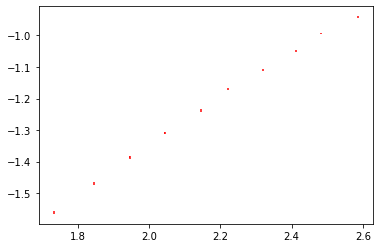

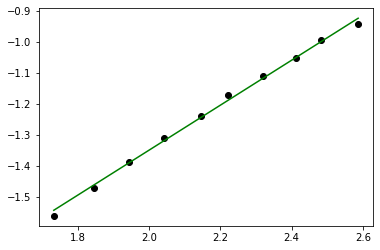

0.7263221790250178 -2.801418229393809


In [59]:
popt,cov = cf(lineal,x_cent,y_cent,sigma=err_rel_y_cent)
a_cent = popt[0]
b_cent = popt[1]
err_a_cent = cov[0]
err_b_cent = cov[1]

x_adj_cent = np.linspace(min(x_cent),max(x_cent),100)
y_adj_cent= a_cent*x_adj_cent+b_cent

plt.errorbar(x_cent,y_cent,xerr=err_x_cent,yerr=err_y_cent,fmt='red',ls='none')

plt.figure()
plt.scatter(x_cent,y_cent,color='k')
plt.plot(x_adj_cent,y_adj_cent,'g')
plt.show()
plt.close()

print(a_cent,b_cent)

In [66]:
x_mov = np.log(temp_mov)
y_mov = np.log(dist_mov)
err_x_mov = err_t/temp_mov
err_y_mov = err_dist/dist_mov

err_rel_x_mov = err_x_mov/abs(x_mov)
err_rel_y_mov = err_y_mov/abs(y_mov)

t_ovr_x = 0
t_eq_x = 0
x_ovr_t = 0
for i in range(len(x_mov)):
    if err_rel_x_mov[i] < 0.1*err_rel_y_mov[i]:
        t_ovr_x += 1
    elif err_rel_y_mov[i] < 0.1*err_rel_x_mov[i]:
        x_ovr_t += 1
    else:
        t_eq_x += 1

print(t_ovr_x,t_eq_x,x_ovr_t)

0 10 0


In [67]:
z = 0
while t_ovr_x <= t_eq_x:
    t_ovr_x = 0
    t_eq_x = 0
    popt,cov = cf(lineal,x_mov,y_mov,sigma=err_rel_y_mov)
    a_mov = popt[0]
    err_y_mov = np.sqrt((a_mov*err_x_mov)**2+err_y_mov**2)
    err_rel_y_mov = err_y_mov/abs(y_mov)
    for i in range(len(x_mov)):
        if err_rel_x_mov[i] < 0.1*err_rel_y_mov[i]:
            t_ovr_x += 1
        else:
            t_eq_x += 1
    z += 1

print(t_ovr_x)
print(z)

6
148


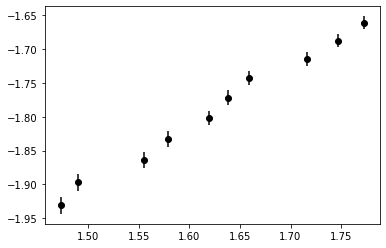

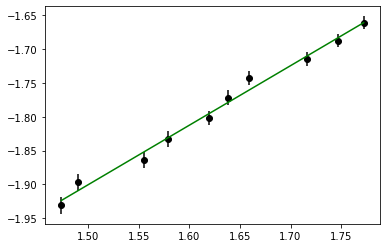

0.8811817770007723 -3.222437085718485
[ 8.49687128  8.73321722  9.29684998  9.59948774 10.02043746 10.29558366
 10.59594134 11.16536233 11.55460439 11.90734112]


In [71]:
popt,cov = cf(lineal,x_mov,y_mov,sigma=err_rel_y_mov)
a_mov = popt[0]
b_mov = popt[1]
err_a_mov = cov[0]
err_b_mov = cov[1]

x_adj_mov = np.linspace(min(x_mov),max(x_mov),100)
y_adj_mov= a_mov*x_adj_mov+b_mov

plt.errorbar(x_mov,y_mov,xerr=err_x_mov,yerr=err_y_mov,fmt='k',ls='none')
plt.scatter(x_mov,y_mov,color='k')

plt.figure()
plt.scatter(x_mov,y_mov,color='k')
plt.errorbar(x_mov,y_mov,xerr=err_x_mov,yerr=err_y_mov,fmt='k',ls='none')
plt.plot(x_adj_mov,y_adj_mov,'g')
plt.show()
plt.close()

print(a_mov,b_mov)